# Analysis of Stochastic Processes

Author: Jake VanderPlas  
License: BSD  

The figure produced by this code is published in the textbook  
*"Statistics, Data Mining, and Machine Learning in Astronomy"* (2013)  

For more information, see http://astroML.github.com  
To report a bug or issue, use the following forum: https://groups.google.com/forum/#!forum/astroml-general  

## Introduction
Stochastic variability includes behavior that is not predictable forever as in the periodic case, but
unlike temporally localized events, variability is always there. Typically, the underlying physics is
so complex that we cannot deterministically predict future values.  
Despite their seemingly irregular behavior, stochastic processes can be quantified. In this notebook, we will mainly discuss **autocorrelation**, **autoregressive** and **damped random walk** models in analyzing stochastic processes.

## Import functions
In this notebook, we mainly use functions from *astroML.time_series* and from *astroML.fourier*.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.time_series import generate_power_law
from astroML.fourier import PSD_continuous

from astroML.time_series import lomb_scargle, generate_damped_RW
from astroML.time_series import ACF_scargle, ACF_EK

## The autocorrelation and structure functions
One of the main statistical tools for the analysis of stochastic variability is the **autocorrelation
function**. It represents a specialized case of the correlation function of two functions, f(t) and g(t),
scaled by their standard deviations, and defined at time lag $\Delta t$ as
$$CF(\Delta t) = \frac{lim_{T \rightarrow \infty} \frac{1}{T} \int_{(T)}f(t)g(t+ \Delta t)dt}{\sigma_f \sigma_g}$$
where $\sigma_f$ and $\sigma_g$ are standard deviations of f(t) and g(t), respectively. With this normalization, the
correlation function is unity for $\Delta t$ = 0 (without normalization by standard deviation, the above
expression is equal to the covariance function). It is assumed that both f and g are statistically
weakly stationary functions, which means that their mean and autocorrelation function (see below)
do not depend on time. The correlation function yields information about the time delay
between two processes. If one time series is produced from another one by simply shifting the time
axis by tlag, their correlation function has a peak at $\Delta t = t_{lag}$.  
  
With $f(t) = g(t) = y(t)$, the autocorrelation of y(t) defined at time lag $\Delta t$ is
$$ACF(\Delta t) = \frac{lim_{T \rightarrow \infty} \frac{1}{T} \int_{(T)}y(t)y(t+ \Delta t)dt}{\sigma_y^2}$$
The autocorrelation function yields information about the variable timescales present in a process. 
When y values are uncorrelated (e.g., due to white noise without any signal), $ACF(\Delta t) = 0$, except for $ACF(0) =1$. For processes that "retain memory" of previous states only for some characteristic
time $\tau$, the autocorrelation function vanishes for $\Delta t \gg \tau$.   
  
The autocorrelation function and the PSD of function y(t) (i.e. $PSD(f) \equiv |H(f)|^2 + |H(-f)|^2$) are Fourier pairs; this
fact is known as the Wiener-Khinchin theorem and applies to stationary random processes. The
former represents an analysis method in the time domain, and the latter in the frequency domain.
  
The **structure function** is another quantity closely related to the autocorrelation function,
$$SF(\Delta t) = SF_\infty [1-ACF(\Delta t)]^{\frac{1}{2}}$$
where $SF_\infty$ is the standard deviation of the time series evaluated over an infinitely large time
interval (or at least much longer than any characteristic timescale $\tau$).

### Examples of stochastic processes: $1/f$ and $1/f^2$ processes
For a given autocorrelation function or PSD, the corresponding time series can be generated using
the algorithm described in [On generating power law noise](http://adsabs.harvard.edu/full/1995A%26A...300..707T). Essentially, the amplitude of the Fourier transform is given by the
PSD, and phases are assigned randomly; the inverse Fourier transform then generates time series.  
The connection between the PSD and the appearance of time series of two power-law PSDs: $1/f$ and $1/f^2$ is illustrated in figure below.  


#### 1. Generate data for plotting
Let us use 1024 data points, and let $\Delta t = 0.01$ in this case.

In [ ]:
N = 1024
dt = 0.01
factor = 100

t = dt * np.arange(N)
random_state = np.random.RandomState(1)

#### 2. Calculate PSD and compare results
We use *generate_power_law* in *astroML_time_series* package to apply the algorithm [On generating power law noise](http://adsabs.harvard.edu/full/1995A%26A...300..707T) on our generated data.  
In the plot below shows examples of stochastic time series generated from power-law PSDs.
* Plots of generated data (top panels) and the corresponding PSD (bottom panels) are shown.
* Results from $1/f$ power-law (left panels) and from $1/f^2$ (right panel) are shown.
* Dashed lines indicate input PSD, and solid lines are determined from time series shown in the top panels. 


The PSD normalization is such that both cases have similar
power at low frequencies. For this reason, the overall amplitudes (more precisely, the variance) of
the two time series are similar. The power at high frequencies is much larger for the $1/f$ case, and
this is why the corresponding time series has the appearance of noisy data.  
The structure function for the $1/f$ process is constant, and proportional to $t^{1/2}$ for
the $1/f^2$ process (remember that we defined structure function with a square root).

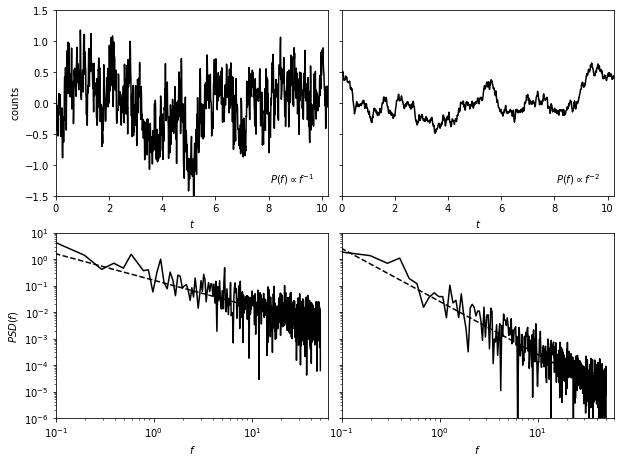

In [ ]:
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(wspace=0.05)

for i, beta in enumerate([1.0, 2.0]):
    # Generate the light curve and compute the PSD
    x = factor * generate_power_law(N, dt, beta, random_state=random_state)
    f, PSD = PSD_continuous(t, x)

    # First axes: plot the time series
    ax1 = fig.add_subplot(221 + i)
    ax1.plot(t, x, '-k')

    ax1.text(0.95, 0.05, r"$P(f) \propto f^{-%i}$" % beta,
             ha='right', va='bottom', transform=ax1.transAxes)

    ax1.set_xlim(0, 10.24)
    ax1.set_ylim(-1.5, 1.5)

    ax1.set_xlabel(r'$t$')

    # Second axes: plot the PSD
    ax2 = fig.add_subplot(223 + i, xscale='log', yscale='log')
    ax2.plot(f, PSD, '-k')
    ax2.plot(f[1:], (factor * dt) ** 2 * (2 * np.pi * f[1:]) ** -beta, '--k')

    ax2.set_xlim(1E-1, 60)
    ax2.set_ylim(1E-6, 1E1)

    ax2.set_xlabel(r'$f$')

    if i == 1:
        ax1.yaxis.set_major_formatter(plt.NullFormatter())
        ax2.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax1.set_ylabel(r'${\rm counts}$')
        ax2.set_ylabel(r'$PSD(f)$')

## Autocorrelation and structure function for evenly and unevenly sampled data
### Evenly sampled data
In the case of **evenly sampled data**, with $t_i = (i-1)\Delta t$, the autocorrelation function of a discretely sampled $y(t)$ is defined as
$$ACF(j) = \frac{\sum^{N-j}_{i=1} [(y_i-\bar{y})(y_{i+j}-\bar{y})]}{\sum^{N}_{i=1}(y_i-\bar{y})^2}$$
The uncertainty of the mean is 
$$\sigma_{\bar{x}} = \frac{\sigma}{\sqrt{N}}[1+2 \sum^N_{j=1}(1-\frac{j}{N})ACF(j)]^{1/2}$$
where $\sigma$ is the homoscedastic measurement error.   
When a time series has a nonvanishing ACF, the uncertainty of its mean is larger than for an uncorrelated data set, where $\sigma_{\bar{x}} = \frac{s}{\sqrt{N}}$.  
When data are unevenly sampled, the ACF cannot be computed using equations above.
  
### Unevenly sampled data
For the case of **unevenly sampled data**, Edelson and Krolik proposed the **"discrete correlation function" (DCF)** in an astronomical context (called the "slot autocorrelation function" in physics). See [The Discrete Correlation Function](https://ui.adsabs.harvard.edu/abs/1988ApJ...333..646E/abstract).  
For discrete unevenly sampled data with homoscedastic errors, they defined a quantity
$$UDCF_{ij} = \frac{(y_i-\bar{y})(g_j-\bar{g})}{[(\sigma_y^2-e_y^2)(\sigma_g^2-e_g^2)^{1/2}]}$$
  
where $e_y$ and $e_g$ are homoscedastic measurement errors for time series y and g. The associated time
lag is $\Delta t_{ij} = ti - tj$. The discrete correlation function at time lag $\Delta t$ is then computed by binning
and averaging $UDCF_{ij}$ over M pairs of points for which $\Delta t-\delta t=2 \leq \delta t_{ij} \leq \Delta t+\delta t/2$, where $\delta t$ is
the bin size. The bin size is a trade-of between accuracy of $DCF(\Delta t)$ and its resolution. Edelson and Krolik showed that even uncorrelated time series will produce values of the cross-correlation $DCF(\Delta t) \sim \pm 1/ \sqrt{M}$.
  
Scargle has developed different techniques to evaluate the discrete Fourier transform, correlation
function and autocorrelation function of unevenly sampled time series (see [Studies in astronomical time series analysis. III.](https://www.osti.gov/biblio/5344858-studies-astronomical-time-series-analysis-iii-fourier-transforms-autocorrelation-functions-cross-correlation-functions-unevenly-spaced-data)).  
Given an unevenly sampled time series, y(t), the essential steps of Scargle's
procedure are as follows:
1. Compute the generalized Lomb-Scargle periodogram for $y(t_i), i = 1,..., N$, namely $P_{LS}(\omega)$.
2. Compute the sampling window function using the generalized Lomb-Scargle periodogram using $z(t_i) = 1, i = 1,..., N$, namely $P_{LS}^W(\omega)$.
3. Compute inverse Fourier transforms for $P_{LS}(\omega)$ and $P^W_{LS}(\omega)$, namely $\rho(t)$ and $\rho^W(t)$, respectively.
4. The autocorrelation function at lag t is $ACF(t) = \rho(t)/ \rho^W(t)$.

### Edelson and Krolik's DCF method and the Scargle method Demonstration
We will see an example of the use of Edelson and Krolik's DCF method and the Scargle method.

#### 1. Generate time-series data
We use do 1000 days worth of magnitudes for this sample data.

In [ ]:
t = np.arange(0, 1E3)
z = 2.0
tau = 300
tau_obs = tau / (1. + z)

np.random.seed(6)
y = generate_damped_RW(t, tau=tau, z=z, xmean=20)

# randomly sample 100 of these
ind = np.arange(len(t))
np.random.shuffle(ind)
ind = ind[:100]
ind.sort()
t = t[ind]
y = y[ind]

# add errors
dy = 0.1
y_obs = np.random.normal(y, dy)

#### 2. Compute ACF via Scargle method
We calculate the ACF following Scargle method process.

In [ ]:
C_S, t_S = ACF_scargle(t, y_obs, dy,
                       n_omega=2. ** 12, omega_max=np.pi / 5.0)

ind = (t_S >= 0) & (t_S <= 500)
t_S = t_S[ind]
C_S = C_S[ind]

        Use astropy.stats.LombScargle instead. [astroML.time_series.ACF]
        Use astropy.stats.LombScargle instead. [astroML.time_series.ACF]


#### 3. Compute ACF via E-K method
We calculate ACF using Edelson and Krolik's DCF method.

In [ ]:
C_EK, C_EK_err, bins = ACF_EK(t, y_obs, dy, bins=np.linspace(0, 500, 51))
t_EK = 0.5 * (bins[1:] + bins[:-1])

#### 4. Compare results
Example of the autocorrelation function for a stochastic process is shown below. 
* The top panel shows a simulated light curve generated using a damped random walk model. 
* The bottom panel shows the corresponding autocorrelation function computed using Edelson and Krolik's DCF method and the Scargle method. 
* The solid line shows the input autocorrelation function used to generate the light curve.  

The two methods produce similar results. Errors are easier to compute for the DCF method and this advantage
is crucial when fitting models to the autocorrelation function.

Text(0, 0.5, 'ACF(t)')

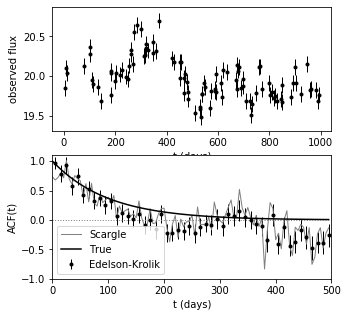

In [ ]:
# Plot the results
fig = plt.figure(figsize=(5, 5))

# plot the input data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('observed flux')

# plot the ACF
ax = fig.add_subplot(212)
ax.plot(t_S, C_S, '-', c='gray', lw=1,
        label='Scargle')
ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1,
            label='Edelson-Krolik')
ax.plot(t_S, np.exp(-abs(t_S) / tau_obs), '-k', label='True')
ax.legend(loc=3)

ax.plot(t_S, 0 * t_S, ':', lw=1, c='gray')

ax.set_xlim(0, 500)
ax.set_ylim(-1.0, 1.1)

ax.set_xlabel('t (days)')
ax.set_ylabel('ACF(t)')

## Autoregressive models
Autocorrelated time series can be analyzed and characterized using stochastic **"autoregressive models."**
Autoregressive models provide a good general description of processes that "retain memory"
of previous states (but are not periodic). An example of such a model is the **random walk**, where
each new value is obtained by adding noise to the preceding value:
$$y_i = y_{i-1} + e_i$$
When $y_{i-1}$ is multiplied by a constant factor greater than 1, the model is known as a geometric
random walk model (used extensively to model stock market data). The noise need not be Gaussian.  
  
The random walk can be generalized to the **linear autoregressive (AR) model** with dependencies
on k past values (i.e., not just one as in the case of random walk). An autoregressive process of
order k, AR(k), for a discrete data set is defined by  
$$y_i = \sum^{k}_{j=1} a_j y_{i-j} + e_i$$
That is, the latest value of y is expressed as a linear combination of the k previous values of y, with
the addition of noise (for random walk, k = 1 and a1 = 1). If the data are drawn from a stationary
process, coefficients aj satisfy certain conditions. The ACF for an AR(k) process is nonzero for all
lags, but it decays quickly.  
  
An autoregressive process defined by $y_i = \sum^{k}_{j=1} a_j y_{i-j} + e_i$ applies only to evenly sampled time series. A
generalization is called the **continuous autoregressive process, CAR(k)**; see [Are the Variations in Quasar Optical Flux Driven by Thermal Fluctuations](https://ui.adsabs.harvard.edu/abs/2009ApJ...698..895K/abstract). The CAR(1)
process has recently received a lot of attention in the context of quasar variability.

In addition to autoregressive models, data can be modeled using the **covariance matrix** (e.g., using
Gaussian process in Gaussian process regression section). For example, for the CAR(1) process,
$$S_{ij} = \sigma^2 exp(-|t_{ij} / \tau|)$$
where $\sigma$ and $\tau$ are model parameters; $\sigma^2$ controls the short timescale covariance ($t_{ij} \ll \tau$),
which decays exponentially on a timescale given by $\tau$. A number of other convenient models
and parametrizations for the covariance matrix are discussed in the context of quasar variability
in [Is quasar variability a damped random walk?](https://arxiv.org/abs/1202.3783).

## Damped random walk model
The CAR(1) process is described by a stochastic differential equation which includes a damping
term that pushes y(t) back to its mean (see [Is quasar variability a damped random walk?](https://arxiv.org/abs/1202.3783)); 

hence, it is also known as damped random walk. In analogy with calling random walk "drunkard's walk," damped random walk could
be called "married drunkard's walk" (who always comes home instead of drifting away).
Following $S_{ij} = \sigma^2 exp(-|t_{ij} / \tau|)$, the autocorrelation function for a damped random walk is
$$ACF(t) = exp(-t/ \tau)$$
where $\tau$ is the characteristic timescale (relaxation time, or damping timescale). Given the $ACF$,
it is easy to show that the structure function is
$$SF(t) = SF_{\infty} [1-exp(-t/ \tau)]^{1/2}$$
where $SF_{\infty}$ is the asymptotic value of the structure function equal to $\sqrt{2} \sigma$, where $\sigma$ has the same definition as in $S_{ij} = \sigma^2 exp(-|t_{ij} / \tau|)$. When the structure function applies to differences of the analyzed process
$$PSD(f) = \frac{\tau^2 SF^2_{\infty}}{1+(2 \pi f \tau)^2}$$
Therefore, the damped random walk is a $1/f^2$ process at high frequencies, just as ordinary random
walk. The "damped nature" is seen as the at PSD at low frequencies ($f \ll 2\pi / \tau$). In the previous figure demonstrating E-K method and Scargle method, a light curve generated using a damped random walk is shown in the top panel.  
  
For evenly sampled data, the $CAR(1)$ process is equivalent to the $AR(1)$ process with $a_1 =
exp(-1 / \tau)$, that is, the next value of $y$ is the damping factor times the previous value plus noise.
The noise for the $AR(1)$ process, $\sigma_{AR}$ is related to $SF_{\infty}$ via
$$\sigma_{AR} = \frac{SF_{\infty}}{\sqrt{2}} [1-exp(-2 / \tau)]^{1/2}$$